In [1]:
# Please make sure all required libraries are installed before running the notebook

In [2]:
#pip install yellowbrick

In [3]:
#pip install threadpoolctl

In [4]:
#pip install --upgrade threadpoolctl

In [5]:
#pip install -U scikit-fuzzy

In [6]:
#pip install umap-learn

In [7]:
import sys
import pandas as pd
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Part 0: Loading the data

In [8]:
import numpy as np
import time
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle
from IPython.display import Image
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.neighbors import KNeighborsClassifier
import skfuzzy as fuzz
import umap.umap_ as umap
import warnings; warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="spectral initialisation failed")


###############################################################
############### Part 0: Loading the data ######################
###############################################################

# Define the transformation for the data
transform = transforms.Compose([transforms.ToTensor()])  # convert to tensor

# Download the MNIST dataset
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Number of training samples: 60000
Number of testing samples: 10000
Number of classes: 10
Image dimensions: torch.Size([1, 28, 28])
Class labels: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


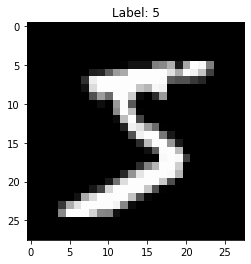

Training samples are balanced


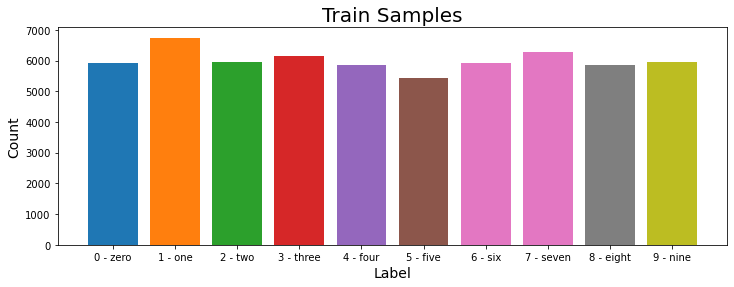

In [9]:
###############################################################
########## In this part we will perform a short EDA ###########
###############################################################

classes = trainset.classes
num_classes = len(classes)
n_train = len(trainset)
n_test = len(testset)
print('Number of training samples:', n_train)
print('Number of testing samples:', n_test)
print('Number of classes:', num_classes)
print('Image dimensions:', trainset[0][0].shape)
print('Class labels:', classes)

# Get a single image from the dataset, convert the tensor to np array and reshape it
image, label = trainset[0]
image = image.numpy().squeeze()

# Plot the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

n_samples_per_idx = []
for label in classes:
    indices = [idx for idx, target in enumerate(trainset.targets) if target==label]
    n_samples_per_idx.append(len(trainset.data[indices]))
    
plt.figure(figsize=(12,4))

train_labels = [label for data, label in trainset]
_ , tr_counts = np.unique(train_labels, return_counts=True)
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink",
          "tab:pink", "tab:gray", "tab:olive"]
plt.bar(trainset.classes, tr_counts, color=colors)
plt.xlabel('Label', fontsize="14")
plt.ylabel('Count', fontsize="14")
plt.title('Train Samples',fontsize="20")
plt.plot()
print('Training samples are balanced')

# Part 1: Clustering methods

In [10]:
###############################################################
############### Part 1: Clustering methods ####################
###############################################################

# In this part we decided to use 3 different clustering methods: K-means, K-means++, fuzzy K-means

# Reshape the training images to 1D arrays
X_train = trainset.data.reshape(-1, 784)
X_test = testset.data.reshape(-1, 784)
y_train = trainset.targets.numpy()
y_test = testset.targets.numpy()

# Initialize KMeans model and fit on training set
kmeans = KMeans(n_clusters=num_classes, init="random", n_init='auto', random_state=42)
kmeans.fit(X_train)

# Initialize KMeans++ model and fit on training set
kmeans_pp = KMeans(n_clusters=num_classes, init='k-means++', n_init='auto', random_state=42)
kmeans_pp.fit(X_train)

# Initialize KMeans model and fit on training set
m = 2   # Fuzziness parameter
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X_train.T, num_classes, m, error=0.005, maxiter=1000, init=None)

In [11]:
#########################################################################
## Evaluate the clustering result using standard evaluation metrics  ####
##          In this part we will evaluate the vanilla kmeans         ####
#########################################################################

predicted_clusters = kmeans.predict(X_train)

# Calculate the silhouette coefficient
SC = silhouette_score(X_train, predicted_clusters)
print(f"Silhouette Coefficient: {SC:.4f}")

# Calculate the homogeneity score
homogeneity = homogeneity_score(y_train, predicted_clusters)
print(f"Homogeneity score: {homogeneity:.4f}")

# Calculate the completeness score
completeness = completeness_score(y_train, predicted_clusters)
print(f"Completeness score: {completeness:.4f}")

Silhouette Coefficient: 0.0585
Homogeneity score: 0.4853
Completeness score: 0.4966


In [12]:
# from yellowbrick.cluster import SilhouetteVisualizer
# visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
# visualizer.fit(X_train)        # Fit the data to the visualizer
# visualizer.show()              # Finalize and render the figure
# plt.savefig('silhouette.jpeg')  # Save the plot as an image
# plt.show()

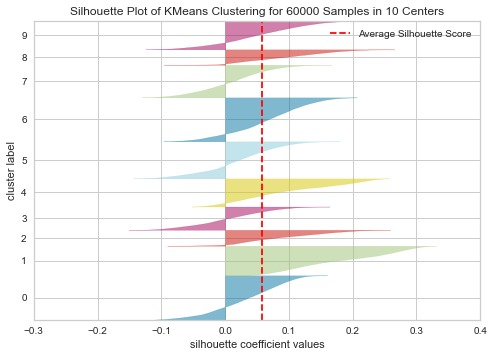

In [13]:
# Runnig SilhouetteVisualizer takes a few moments, we saved the plot image to save time
Image(filename='silhouette.jpeg') 

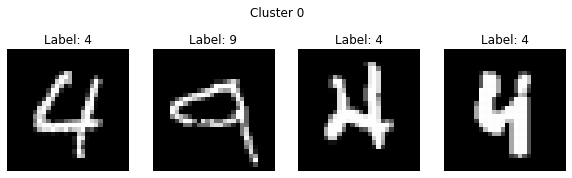

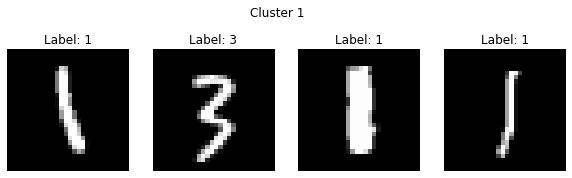

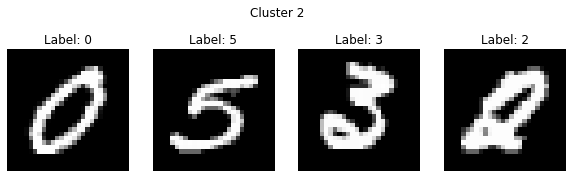

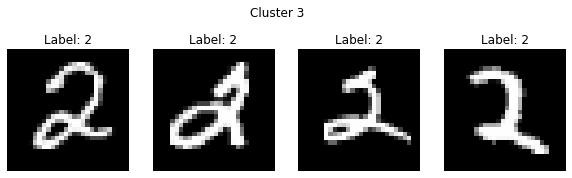

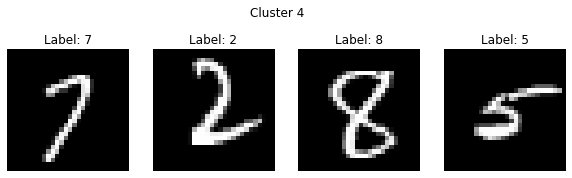

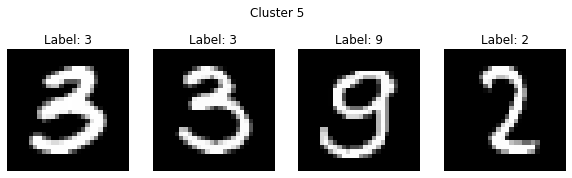

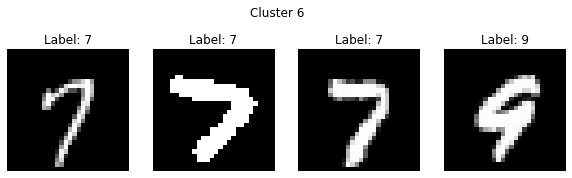

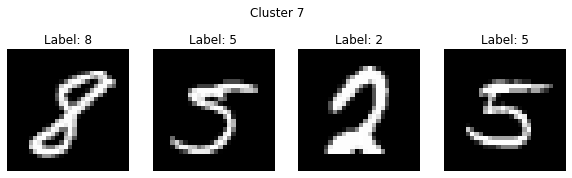

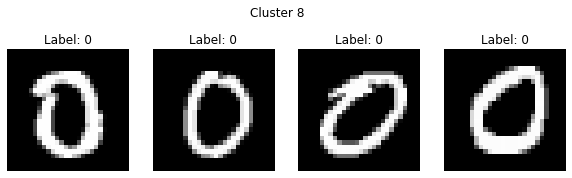

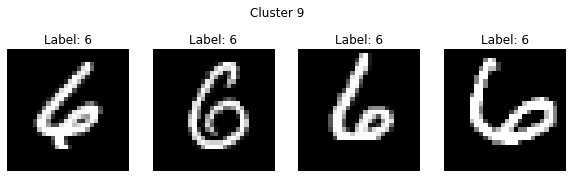

In [14]:
# Visualizing the clusters by displaying a few images from each cluster

num_images_per_cluster = 4

for cluster_idx in range(num_classes):
    # Select the indices of the training samples in the current cluster
    cluster_indices = np.where(predicted_clusters == cluster_idx)[0]
    
    # Select a random subset of the images in the current cluster
    random_indices = np.random.choice(cluster_indices, size=num_images_per_cluster, replace=False)
    
    # Create a figure to display the images in the current cluster
    fig, axs = plt.subplots(1, num_images_per_cluster, figsize=(10, 3))
    fig.suptitle(f'Cluster {cluster_idx}')
    
    # Loop over the selected images
    for i, idx in enumerate(random_indices):
        img, label = trainset[idx]
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f'Label: {label}')
    plt.show()

In [15]:
###############################################################
##########       Building a simple classifier       ###########
###############################################################

def predict_labels(model, reference_labels, X):
    """
    Recieves input data X
    Returns array type prediction of labels correspoding to most frequest label in training cluster
    """
    cluster_pred = model.predict(X)
    label_pred = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        label_pred[i] = reference_labels[cluster_pred[i]]
    return label_pred
    
def retrieve_info(cluster_labels,y_train):
    """
     Associates most probable label with each cluster in cluster model
     returns: dictionary of clusters assigned to each label
    """
    reference_labels = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(cluster_labels))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels

def calc_accuracy(pred, y):
    accuracy = 0.0
    accuracy = np.sum(pred == y) / len(y)
    return accuracy

def calc_metrics(model,true_labels):
    print('Number of clusters: {}'.format(model.n_clusters))
    print('Inertia: {:.2f}'.format(model.inertia_))
    print('Homogeneity: {:.4f}'.format(metrics.homogeneity_score(true_labels,model.labels_)))

In [16]:
# Create reference dictionaries for each cluster method
kmeans_reference_labels = retrieve_info(kmeans.labels_, y_train)
kmeans_pp_reference_labels = retrieve_info(kmeans_pp.labels_, y_train)
kmeans_fuzz_reference_labels = retrieve_info(np.argmax(u, axis=0), y_train)


# Create predictions over test set for each cluster method
kmeans_test_pred = predict_labels(kmeans, kmeans_reference_labels, X_test)
kmeans_pp_test_pred = predict_labels(kmeans_pp, kmeans_pp_reference_labels, X_test)
u_test, _, _, _, _, _ = fuzz.cluster.cmeans_predict(X_test.T, cntr, m, error=0.005, maxiter=1000)

# For fuzzy K-means additional calculation are required since there is no implementation in sklearn
fuzz_test_cluster_labels = np.argmax(u_test, axis=0)
kmeans_fuzzy_test_pred = np.zeros(X_test.shape[0])
for i in range(X_test.shape[0]):
    kmeans_fuzzy_test_pred[i] = kmeans_fuzz_reference_labels[fuzz_test_cluster_labels[i]]
fuzz_homogeneity = metrics.homogeneity_score(y_test, kmeans_fuzzy_test_pred)
fuzz_inertia = (np.abs(X_train - cntr[np.argmax(u, axis=0)])**2).numpy().sum()

In [17]:
###############################################################
#######  Evaluate the performance of the classifiers   ########
###############################################################

print("*** K-means metrics ***")
calc_metrics(kmeans,y_train)
print(f"Testset accuracy: {calc_accuracy(kmeans_test_pred, y_test):.4f}")
print("-----------------------------")

print("*** K-means++ metrics ***")
calc_metrics(kmeans_pp,y_train)
print(f"Testset accuracy: {calc_accuracy(kmeans_pp_test_pred, y_test):.4f}")
print("-----------------------------")

print("*** Fuzzy K-means metrics ***")
print('Number of clusters: {}'.format(num_classes))
print('Inertia: {:.2f}'.format(fuzz_inertia))
print('Homogeneity: {:.4f}'.format(fuzz_homogeneity))
print(f"Testset accuracy: {calc_accuracy(kmeans_fuzzy_test_pred, y_test):.4f} \n")

*** K-means metrics ***
Number of clusters: 10
Inertia: 152992535595.50
Homogeneity: 0.4853
Testset accuracy: 0.5945
-----------------------------
*** K-means++ metrics ***
Number of clusters: 10
Inertia: 153002407387.23
Homogeneity: 0.4932
Testset accuracy: 0.5888
-----------------------------
*** Fuzzy K-means metrics ***
Number of clusters: 10
Inertia: 205700147934.79
Homogeneity: 0.1172
Testset accuracy: 0.2585 



We chose to focuse on determining the number of clusters.
Around ~60 clusters seems to be a good choice.
The explenation for more clusters than possible digits is because of more than one way of sketching a digit.
For example 7 with or without a cross line.


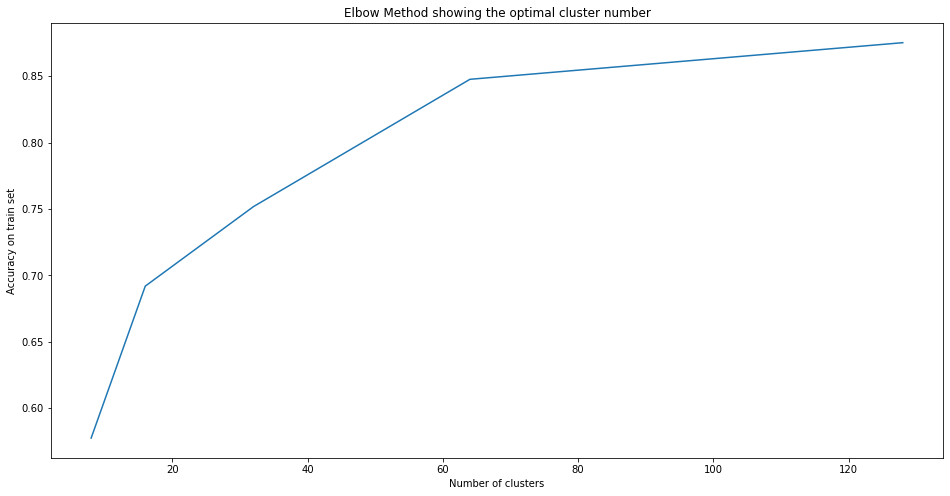

In [18]:
#############################################################################
##    Explore parameters and evaluate their effect on the results          ##
#############################################################################

print("We chose to focuse on determining the number of clusters.")
print("Around ~60 clusters seems to be a good choice.")
print("The explenation for more clusters than possible digits is because of more than one way of sketching a digit.\nFor example 7 with or without a cross line.")

n_clusters = [2**i for i in range(3,8)]
acc =[]
for k in n_clusters:
    kmeans_pp = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    kmeans_pp.fit(X_train)
    kmeans_pp_reference_labels = retrieve_info(kmeans_pp.labels_, y_train)
    kmeans_pp_train_pred = predict_labels(kmeans_pp, kmeans_pp_reference_labels, X_train)
    acc.append(calc_accuracy(kmeans_pp_train_pred, y_train))

plt.figure(figsize=(16,8))
plt.plot(n_clusters, acc)
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy on train set')
plt.title('Elbow Method showing the optimal cluster number')
plt.show()

In [19]:
kmeans_pp = KMeans(n_clusters=64, init='k-means++', n_init='auto', random_state=42)
kmeans_pp.fit(X_train)
kmeans_pp_reference_labels = retrieve_info(kmeans_pp.labels_, y_train)
kmeans_pp_test_pred = predict_labels(kmeans_pp, kmeans_pp_reference_labels, X_test)

print("*** K-means++ metrics ***")
calc_metrics(kmeans_pp,y_train)
print(f"Testset accuracy: {calc_accuracy(kmeans_pp_test_pred, y_test):.4f}")

*** K-means++ metrics ***
Number of clusters: 64
Inertia: 116014873570.50
Homogeneity: 0.7651
Testset accuracy: 0.8548


In [20]:
# ###############################################################
# ########## Part 4: Classification of the raw data #############
# ###############################################################

# # In this part we chose to use Support vecotr machines as a benchmark for the classification task
# from sklearn import svm
# # svmClassifier = svm.SVC(kernel='rbf', gamma='scale')
# # svmClassifier.fit(X_train, y_train)
# # pickle.dump(svmClassifier, open('svm.pkl', 'wb')) # Save the svm model for future use
# pickled_svm = pickle.load(open('svm.pkl', 'rb'))
# test_pred = pickled_svm.predict(X_test)
# accuracySVM = calc_accuracy(test_pred, y_test)
# print(f"Support Vector Machine accuracy over testset: {accuracySVM:.4f}")

In [21]:
# from sklearn.linear_model import LogisticRegression
# # logisticClassifier = LogisticRegression(C=0.01, penalty='l1', solver='saga', tol=0.1, multi_class='multinomial')
# # logisticClassifier.fit(X_train, y_train)
# # pickle.dump(logisticClassifier, open('logistic.pkl', 'wb')) # Save the logistic model for future use
# pickled_log = pickle.load(open('logistic.pkl', 'rb'))
# log_pred = pickled_log.predict(X_test)
# log_acc = calc_accuracy(log_pred, y_test)
# print(f"Logistic regression testset accuracy: {log_acc:.4f}")

# Part 2: Dimensionality Reduction
For at least three different dimensionality reduction methods of your choice perform: \
a) Reduce the dimensionality of the data and visualize the first few features in the new space. \
b) Train at least one classifier on the data in the new space. \
c) Evaluate the performance of the classifiers \
d) Explore different parameters for the dimensionality reduction and evaluate their effect on
the results.

In [22]:
# Note runtime for full exeprimentation is exeptionally long
# When IS_EXPERIMENT_RUN is set to True all exepriments will run
# When IS_EXPERIMENT_RUN is set to False a chosen set of experiments will run (recommeded for running the notebook)
IS_EXPERIMENT_RUN = True

### helping functions

In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from datetime import datetime

mnist = load_digits()


CLF_TO_TEST = ['mlp', 'svm'] if IS_EXPERIMENT_RUN else ['svm']

def _reduce_dim(dim_reducer, X_train, X_test):
    dim_reducer.fit(X_train)
    
    X_train_new_space = dim_reducer.transform(X_train)
    X_test_new_space = dim_reducer.transform(X_test)
    return X_train_new_space, X_test_new_space

def _train_and_evaluate_results(dim_reducer, X_train_new_space, X_test_new_space, y_train, y_test, clf_type='mlp'):
    assert clf_type in CLF_TO_TEST
    clf = MLPClassifier(solver = 'lbfgs') if clf_type=='mlp' else svm.SVC(kernel='rbf', gamma='scale')

    clf.fit(X_train_new_space, y_train)
    test_score = clf.score(X_test_new_space, y_test)
    
    print(f'{dim_reducer} - classifier of type {clf} in the new space got score of: {test_score}')
    
    return test_score
    
def _visualize_features(X_test_new_space,  y_test):
    # visuallize
    
    max_components = min(6, X_test_new_space.shape[1])
    n_plts = max_components//2
    
    fig , ax = plt.subplots(1, n_plts,  figsize=(16, 5))

    fig.suptitle(f'First {max_components} Features In New Space of {X_test_new_space.shape[1]} Features')
    
    for i, principal_component in enumerate(range(0, max_components, 2)):
        curr_ax = ax[i] if n_plts > 1 else ax
        curr_ax.scatter(X_test_new_space[:, principal_component], 
                      X_test_new_space[:, (principal_component+1)], c=y_test.astype(np.uint8), cmap='jet')
        curr_ax.set_xlabel(f'pc-{principal_component}')
        curr_ax.set_ylabel(f'pc-{principal_component+1}')
    plt.show() 

def _run_tsne(tsne_clf, X_train, y_train, X_test, y_test, clf_type='mlp', n_neighbors=2, sampling_test=None):
    assert clf_type in CLF_TO_TEST
    start_time = datetime.utcnow()
    X_train_transformed = tsne_clf.fit_transform(X_train)
    # tsne 
    
    X_test_subset = X_test if not sampling_test else X_test[:sampling_test]
    y_test_subset = y_test[:len(X_test_subset)]
    
    # For transformsing X_train to the new space,
    nearest_nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(X_train)

    distances, indices = nearest_nbrs.kneighbors(X_test_subset)
    k_similarities =  distances / np.sum(distances, axis=1)[:, np.newaxis]
    
    test_transformed = np.zeros((X_test_subset.shape[0], X_train_transformed.shape[1]))

    for k_neighbor in range(indices.shape[1]):
        test_transformed += k_similarities[:, k_neighbor][:, np.newaxis] * X_train_transformed[indices[:, k_neighbor]]

    print(f'visualizing new space, using TSNE ({tsne_clf}) along with NearestNeighbors ({NearestNeighbors})')
    _visualize_features(test_transformed, y_test_subset)
    
    # clf
    clf = MLPClassifier(solver = 'lbfgs') if clf_type=='mlp' else svm.SVC(kernel='rbf', gamma='scale')
    clf.fit(X_train, y_train)
    test_score = clf.score(X_test_subset, y_test_subset)
    
    duration = (datetime.utcnow() - start_time).total_seconds()
    return test_score, duration  

In [24]:
from datetime import datetime
all_results = []
df = pd.DataFrame([])
#df = pd.read_csv('all_results.csv', index_col=0)

### Baseline classifier, no dimensionality reduction

In [25]:
import tqdm
# base line - no dimentionallity reduction

for clf_type in tqdm.tqdm(CLF_TO_TEST):
    start_time = datetime.utcnow()
    clf = MLPClassifier(solver = 'lbfgs', max_iter = 10^5) if clf_type=='mlp' else svm.SVC(kernel='rbf', gamma='scale')
    clf.fit(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    duration = (datetime.utcnow() - start_time).total_seconds()
    
    df = df.append([{'n_components': None, 'test_score': test_score,
                           'duration': duration, 'clf_type': clf_type}])

100%|██████████| 2/2 [05:14<00:00, 157.29s/it]


### PCA Experiments

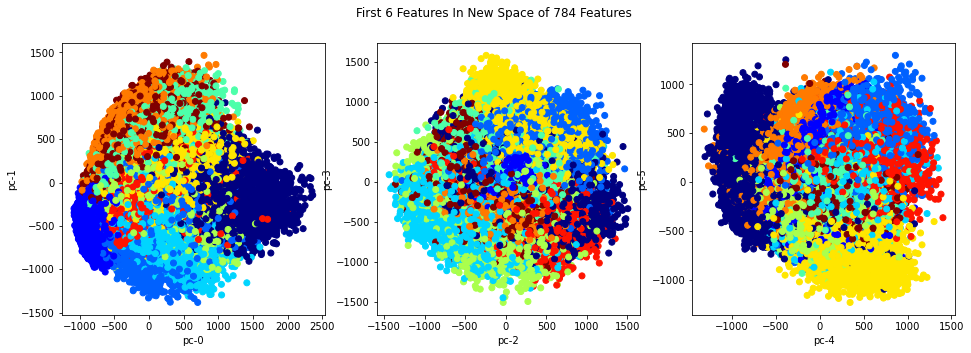

PCA(n_components=60) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.964
PCA(n_components=54) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.9639
PCA(n_components=48) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.9634
PCA(n_components=42) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.9658
PCA(n_components=36) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.9657
PCA(n_components=30) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.9665
PCA(n_components=24) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.9635
PCA(n_components=18) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.9563
PCA(n_components=12) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.9296
PCA(n_compo

In [26]:
full_n_components = X_train.shape[1]


n_components = X_test.shape[1]
curr_pca = PCA(n_components=n_components)
X_train_new_space, X_test_new_space = _reduce_dim(curr_pca, X_train, X_test)

_visualize_features(X_train_new_space, y_train)

n_componens_to_run = range(60, 4, -6) if IS_EXPERIMENT_RUN else [22] # todo

for clf_type in CLF_TO_TEST:
    for n_components in n_componens_to_run:
        start_time = datetime.utcnow()
        curr_pca = PCA(n_components=n_components)
        X_train_new_space, X_test_new_space = _reduce_dim(curr_pca, X_train, X_test)
        duration = (datetime.utcnow() - start_time).total_seconds()
        score = _train_and_evaluate_results(curr_pca, X_train_new_space, 
                                            X_test_new_space, y_train, y_test, clf_type=clf_type)
        df = df.append([{'alg': str(curr_pca), 'n_components': n_components, 'test_score': score,
                           'duration': duration, 'clf_type': clf_type}])

In [27]:
n_componens_to_run = [2, 4] if IS_EXPERIMENT_RUN else [] # todo

for clf_type in CLF_TO_TEST:
    for n_components in n_componens_to_run:
        start_time = datetime.utcnow()
        curr_pca = PCA(n_components=n_components)
        X_train_new_space, X_test_new_space = _reduce_dim(curr_pca, X_train, X_test)
        duration = (datetime.utcnow() - start_time).total_seconds()
        score = _train_and_evaluate_results(curr_pca, X_train_new_space, 
                                            X_test_new_space, y_train, y_test, clf_type=clf_type)
        df = df.append([{'alg': str(curr_pca), 'n_components': n_components, 'test_score': score,
                   'duration': duration, 'clf_type': clf_type}])

PCA(n_components=2) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.4027
PCA(n_components=4) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.604
PCA(n_components=2) - classifier of type SVC() in the new space got score of: 0.4779
PCA(n_components=4) - classifier of type SVC() in the new space got score of: 0.6631


### t-SNE barnes_hut Experiemnts

  0%|          | 0/5 [00:00<?, ?it/s]

visualizing new space, using TSNE (TSNE(perplexity=2, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


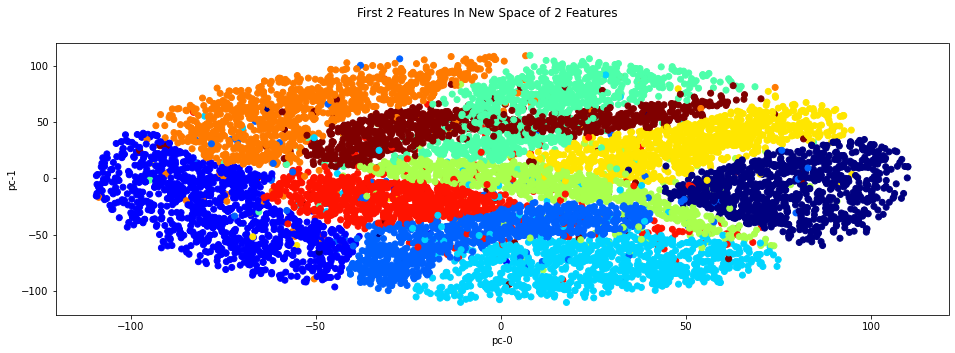

 20%|██        | 1/5 [12:43<50:52, 763.20s/it]

visualizing new space, using TSNE (TSNE(perplexity=5, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


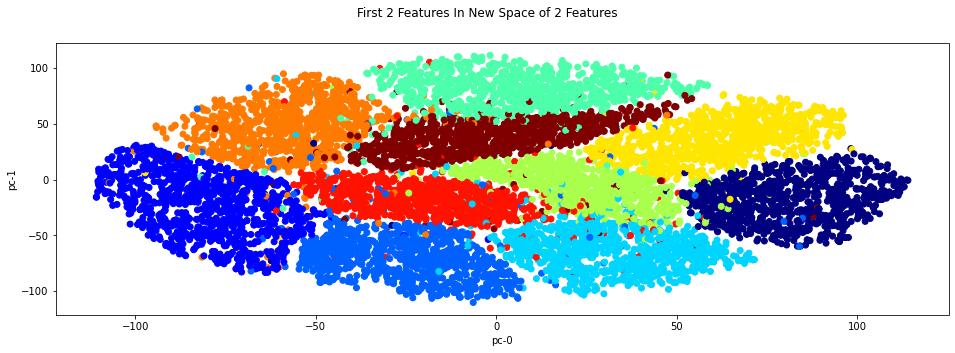

 40%|████      | 2/5 [25:38<38:31, 770.35s/it]

visualizing new space, using TSNE (TSNE(perplexity=30, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


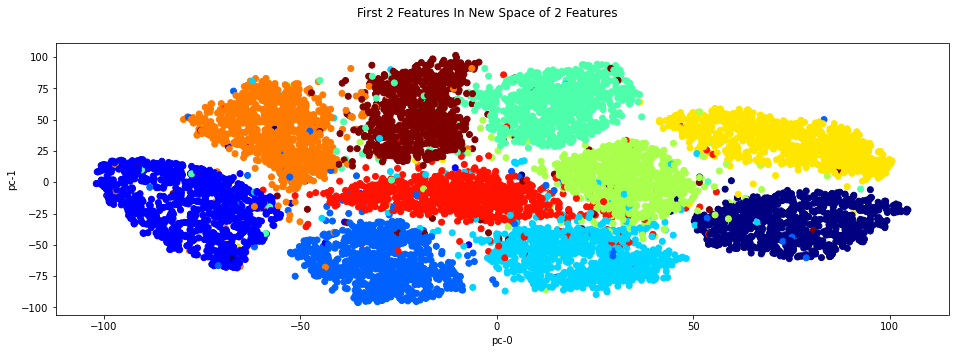

 60%|██████    | 3/5 [39:31<26:37, 798.74s/it]

visualizing new space, using TSNE (TSNE(perplexity=50, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


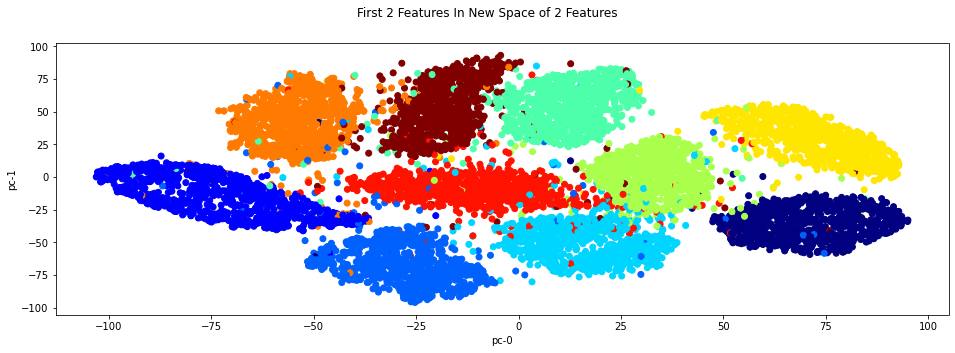

 80%|████████  | 4/5 [54:00<13:46, 826.68s/it]

visualizing new space, using TSNE (TSNE(perplexity=100, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


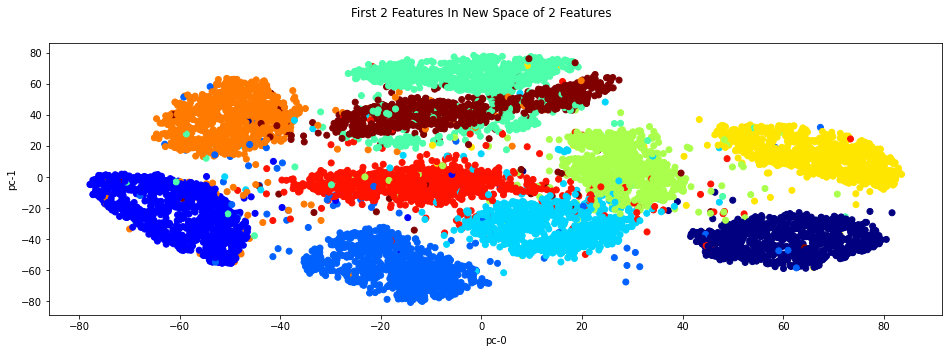

  0%|          | 0/5 [00:00<?, ?it/s]

visualizing new space, using TSNE (TSNE(perplexity=2, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


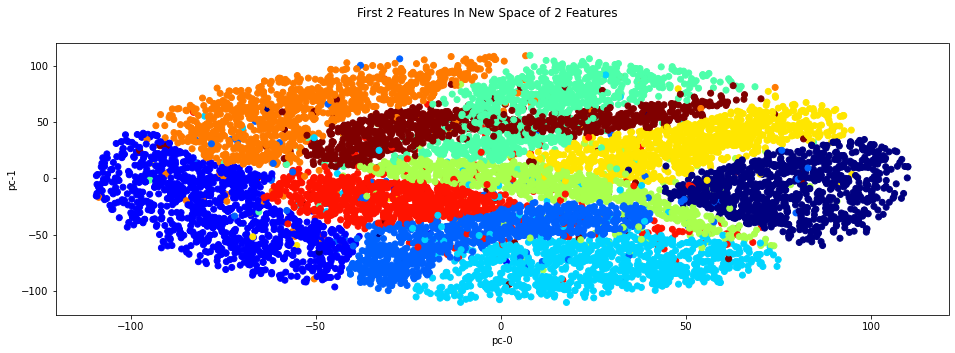

 20%|██        | 1/5 [16:35<1:06:23, 995.77s/it]

visualizing new space, using TSNE (TSNE(perplexity=5, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


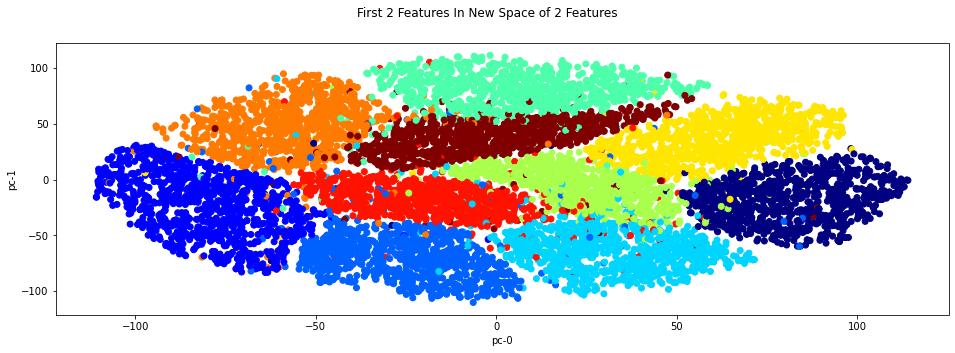

 40%|████      | 2/5 [33:15<49:53, 997.94s/it]  

visualizing new space, using TSNE (TSNE(perplexity=30, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


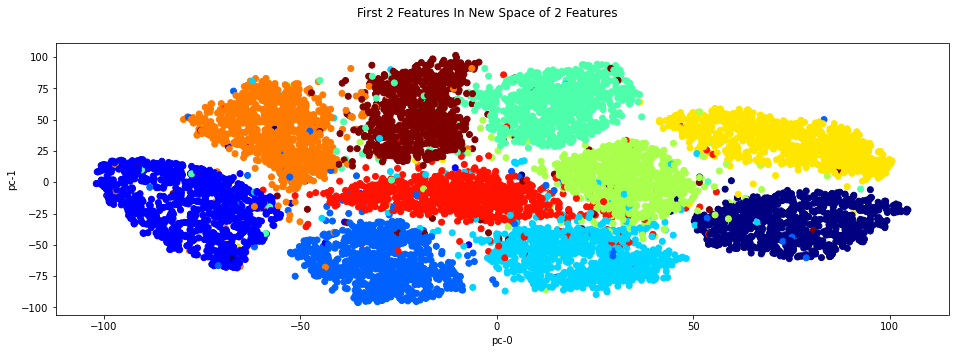

 60%|██████    | 3/5 [50:51<34:09, 1024.65s/it]

visualizing new space, using TSNE (TSNE(perplexity=50, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


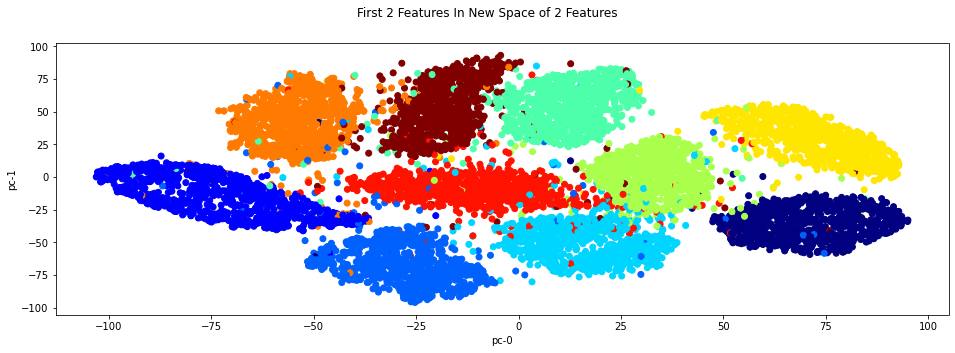

 80%|████████  | 4/5 [1:08:51<17:26, 1046.39s/it]

visualizing new space, using TSNE (TSNE(perplexity=100, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


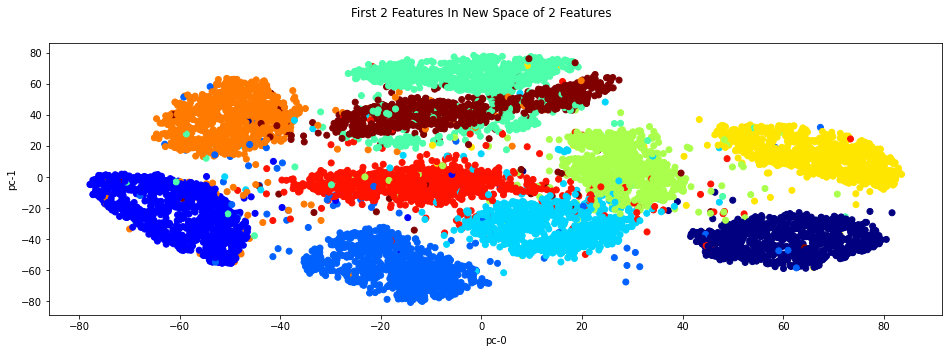

100%|██████████| 5/5 [1:28:22<00:00, 1060.43s/it]


In [28]:
import tqdm

perplexity_to_run = [2, 5, 30, 50, 100] if IS_EXPERIMENT_RUN else [30] # todo

for clf_type in CLF_TO_TEST:
    for perplexity in tqdm.tqdm(perplexity_to_run):
        n_components = 2
        method = 'barnes_hut'
        sampling_test = None
        n_neighbors = 2
        params = {'n_components': n_components, 'perplexity': perplexity, 'method': method}
        tsne_clf = TSNE(**params, random_state=42)
        score, duration = _run_tsne(tsne_clf, X_train, y_train, X_test, y_test, clf_type=clf_type, n_neighbors=2, sampling_test=sampling_test)

        df = df.append([{'alg': str(tsne_clf), 'n_components': n_components, 'test_score': score,
                               'duration': duration, 'params': str(params), 'clf_type': clf_type, 'n_neighbors': n_neighbors, 'sampling_test': sampling_test}])
    
#         df.to_csv('all_results.csv')

  0%|          | 0/5 [00:00<?, ?it/s]

visualizing new space, using TSNE (TSNE(perplexity=2, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


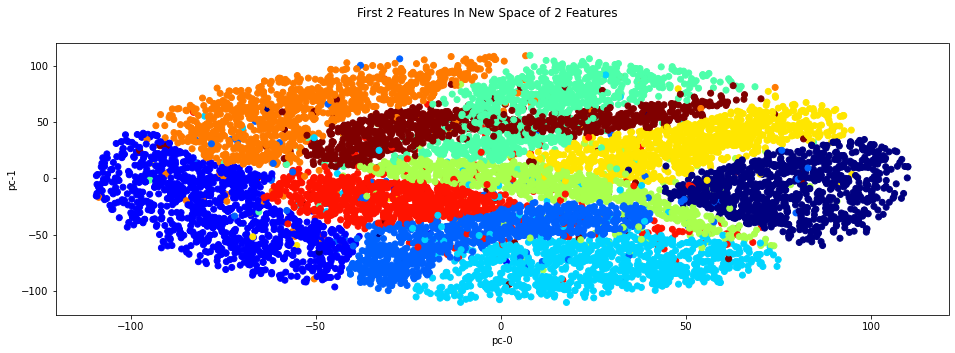

 20%|██        | 1/5 [12:27<49:48, 747.06s/it]

visualizing new space, using TSNE (TSNE(perplexity=5, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


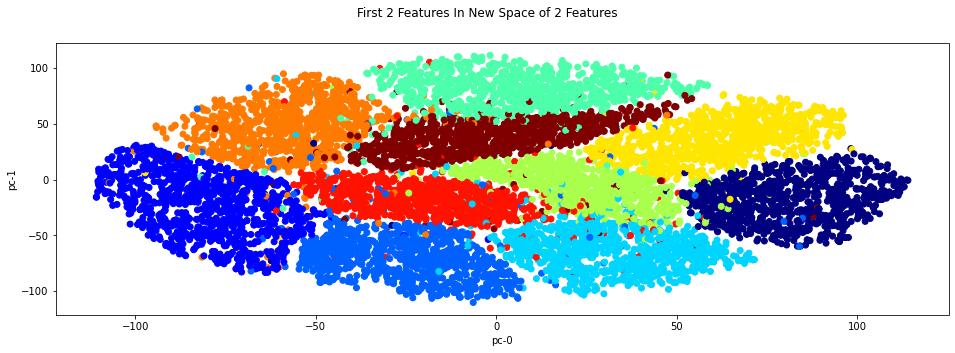

 40%|████      | 2/5 [25:20<38:07, 762.59s/it]

visualizing new space, using TSNE (TSNE(perplexity=30, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


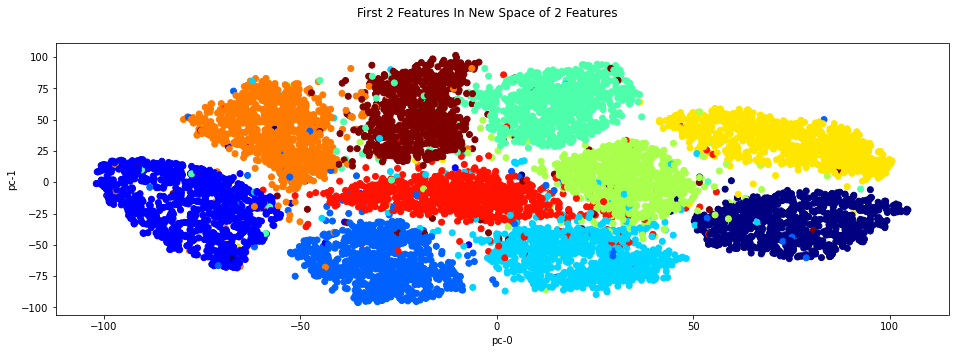

 60%|██████    | 3/5 [39:00<26:17, 788.83s/it]

visualizing new space, using TSNE (TSNE(perplexity=50, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


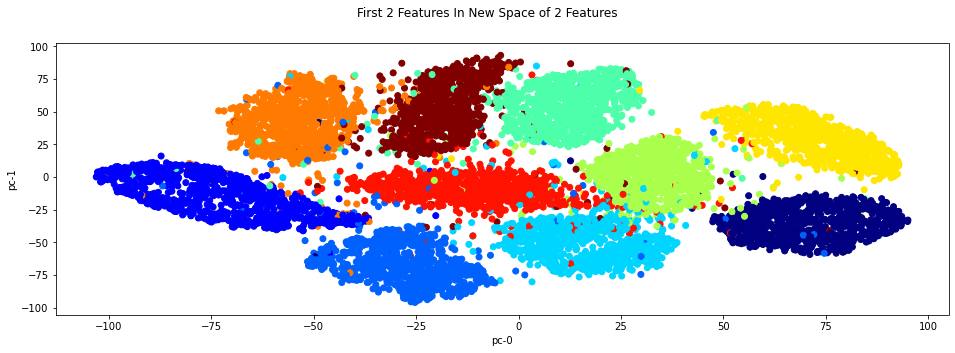

 80%|████████  | 4/5 [53:14<13:34, 814.65s/it]

visualizing new space, using TSNE (TSNE(perplexity=100, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


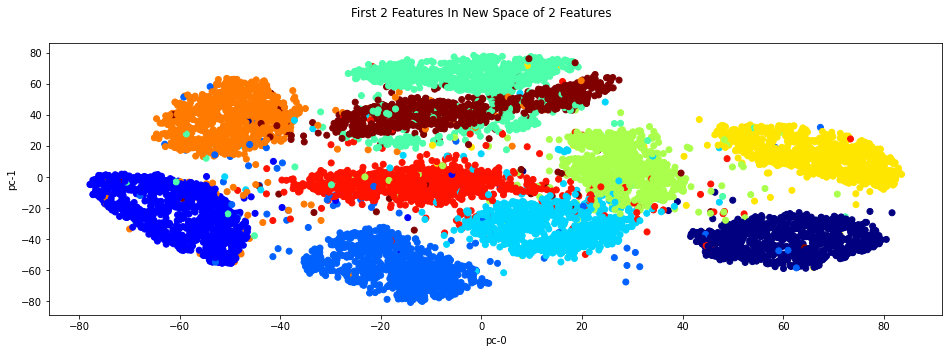

  0%|          | 0/5 [00:00<?, ?it/s]

visualizing new space, using TSNE (TSNE(perplexity=2, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


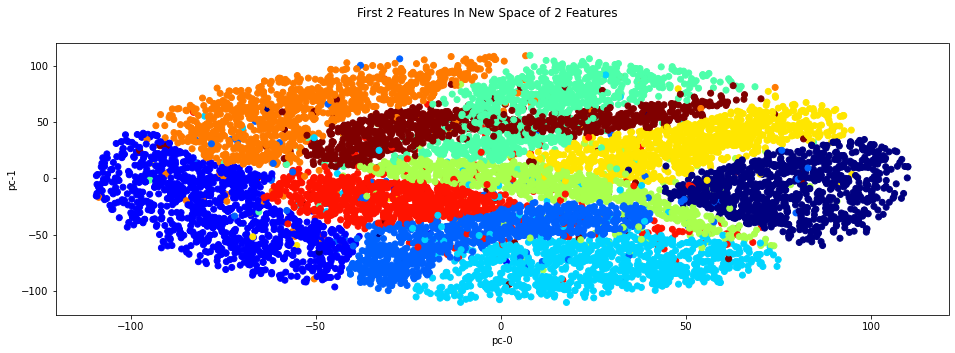

 20%|██        | 1/5 [16:16<1:05:04, 976.23s/it]

visualizing new space, using TSNE (TSNE(perplexity=5, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


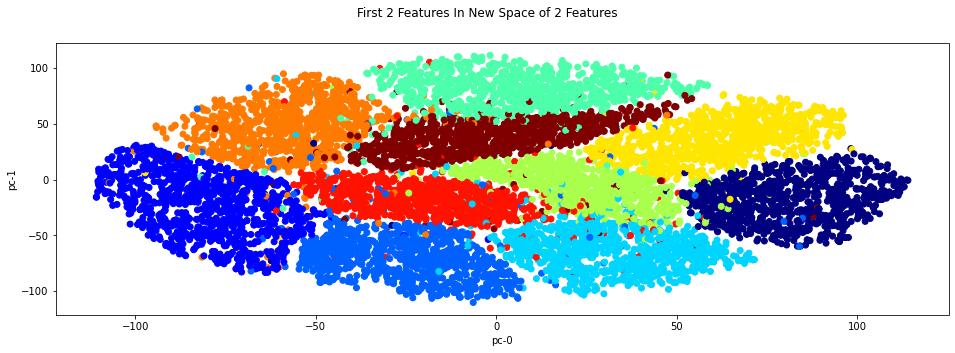

 40%|████      | 2/5 [32:37<48:56, 978.92s/it]  

visualizing new space, using TSNE (TSNE(perplexity=30, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


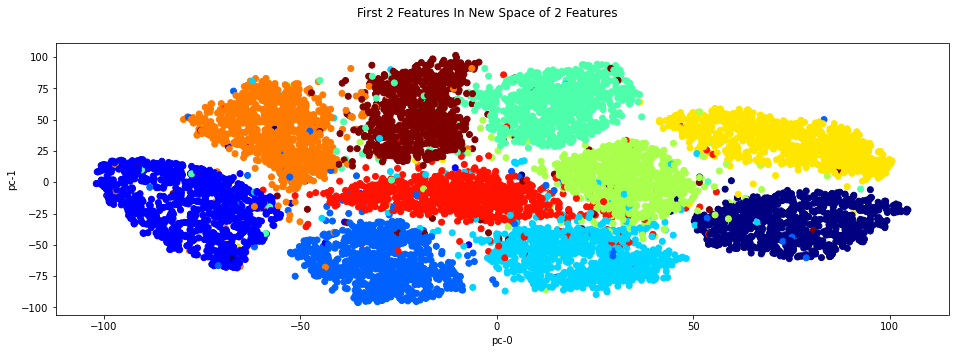

 60%|██████    | 3/5 [50:00<33:37, 1008.58s/it]

visualizing new space, using TSNE (TSNE(perplexity=50, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


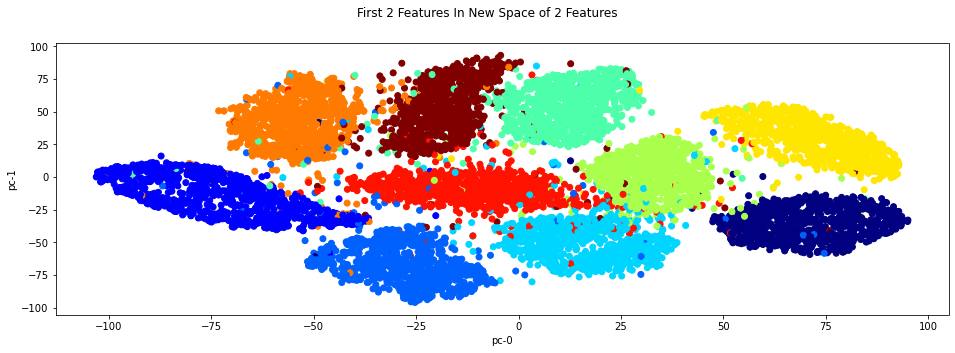

 80%|████████  | 4/5 [1:07:59<17:16, 1036.19s/it]

visualizing new space, using TSNE (TSNE(perplexity=100, random_state=42)) along with NearestNeighbors (<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>)


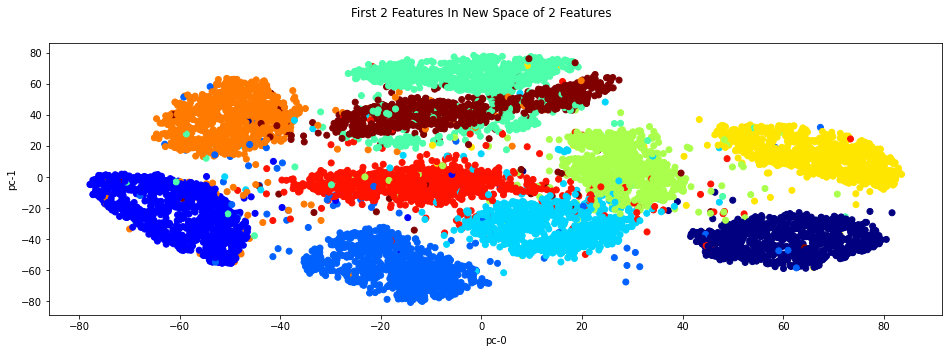

100%|██████████| 5/5 [1:27:12<00:00, 1046.46s/it]


In [29]:
import tqdm

perplexity_to_run = [2, 5, 30, 50, 100] if IS_EXPERIMENT_RUN else [] # todo

for clf_type in CLF_TO_TEST:
    for perplexity in tqdm.tqdm(perplexity_to_run):
        n_components = 2
        method = 'barnes_hut'
        sampling_test = None
        n_neighbors = 1
        params = {'n_components': n_components, 'perplexity': perplexity, 'method': method}
        tsne_clf = TSNE(**params, random_state=42)
        score, duration = _run_tsne(tsne_clf, X_train, y_train, X_test, y_test, clf_type=clf_type, n_neighbors=2, sampling_test=sampling_test)

        df = df.append([{'alg': str(tsne_clf), 'n_components': n_components, 'test_score': score,
                               'duration': duration, 'params': str(params), 'clf_type': clf_type, 'n_neighbors': n_neighbors, 'sampling_test': sampling_test}])
    
#         df.to_csv('all_results.csv')

### UMAP Experiments

C:\Users\ADAMV\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\ADAMV\anaconda3\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\ADAMV\anaconda3\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\ADAMV\anaconda3\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noi

visualizing features of UMAP(n_neighbors=2, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


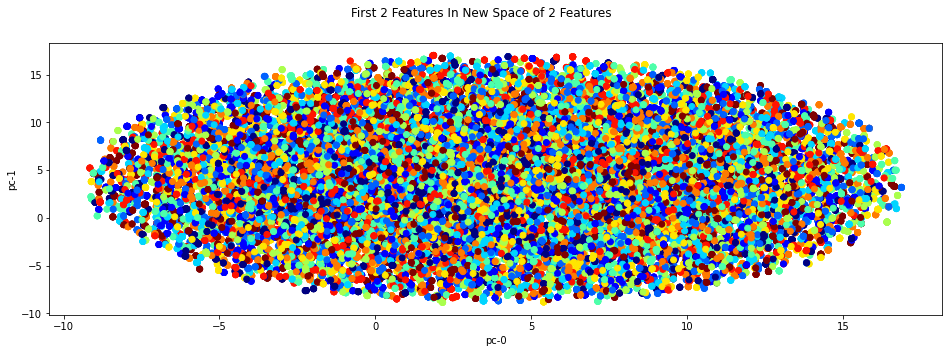

UMAP(n_neighbors=2, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.1334
visualizing features of UMAP(n_neighbors=5, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


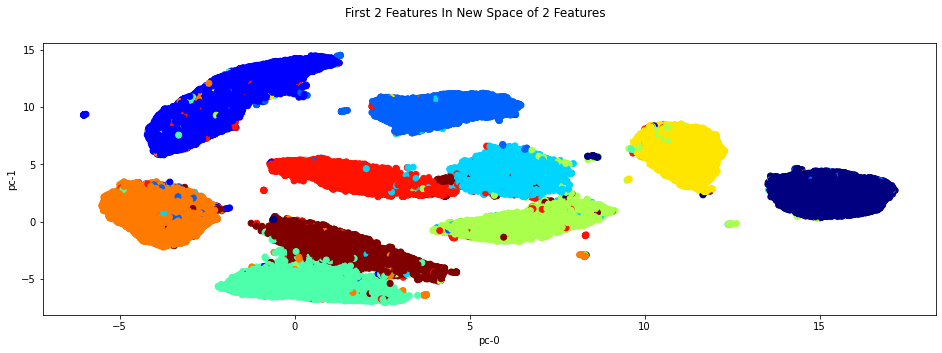

UMAP(n_neighbors=5, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.899
visualizing features of UMAP(n_neighbors=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


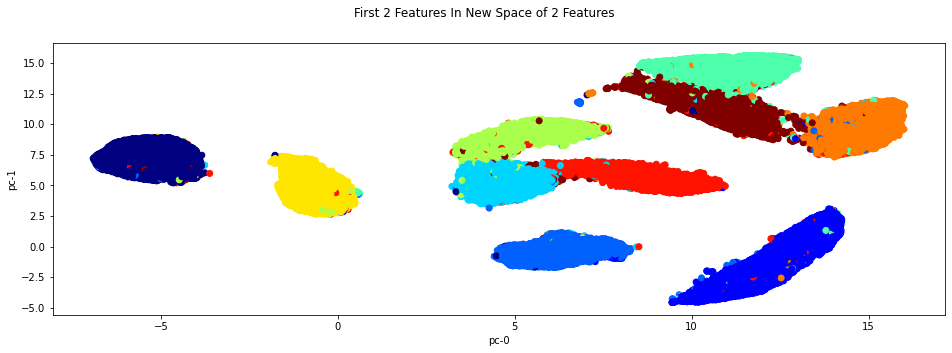

UMAP(n_neighbors=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.9454
visualizing features of UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


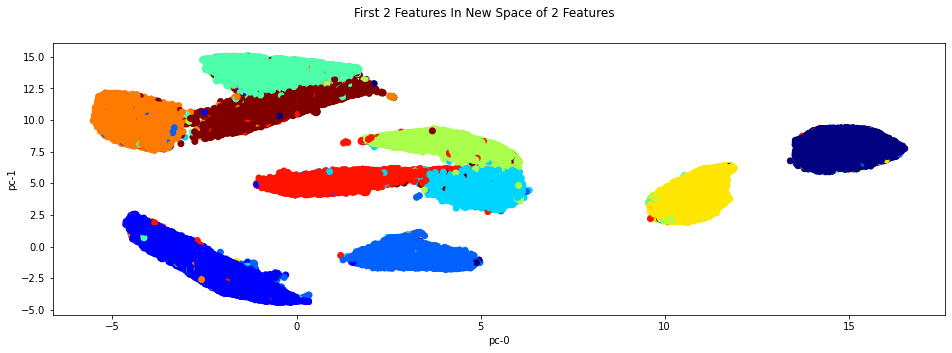

UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}) - classifier of type MLPClassifier(solver='lbfgs') in the new space got score of: 0.9543


C:\Users\ADAMV\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\ADAMV\anaconda3\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\ADAMV\anaconda3\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\ADAMV\anaconda3\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noi

visualizing features of UMAP(n_neighbors=2, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


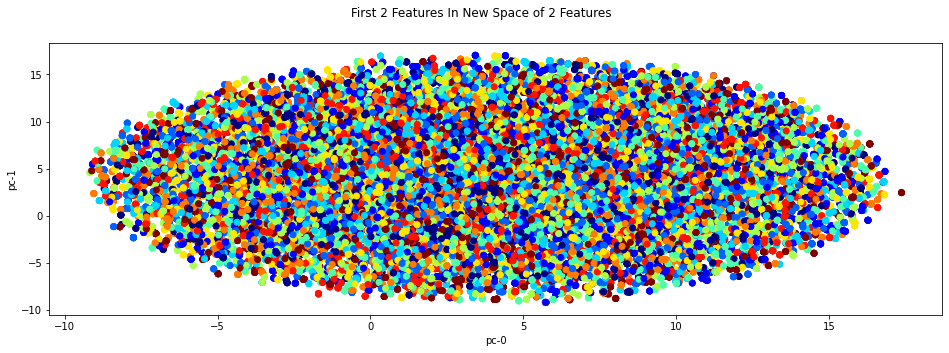

UMAP(n_neighbors=2, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}) - classifier of type SVC() in the new space got score of: 0.1223
visualizing features of UMAP(n_neighbors=5, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


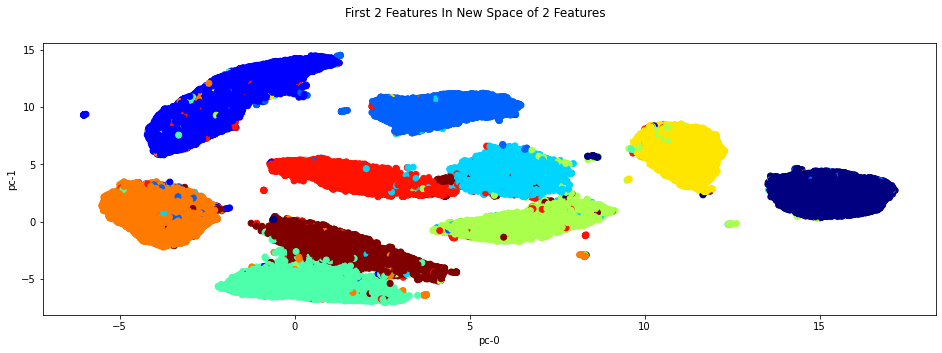

UMAP(n_neighbors=5, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}) - classifier of type SVC() in the new space got score of: 0.899
visualizing features of UMAP(n_neighbors=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


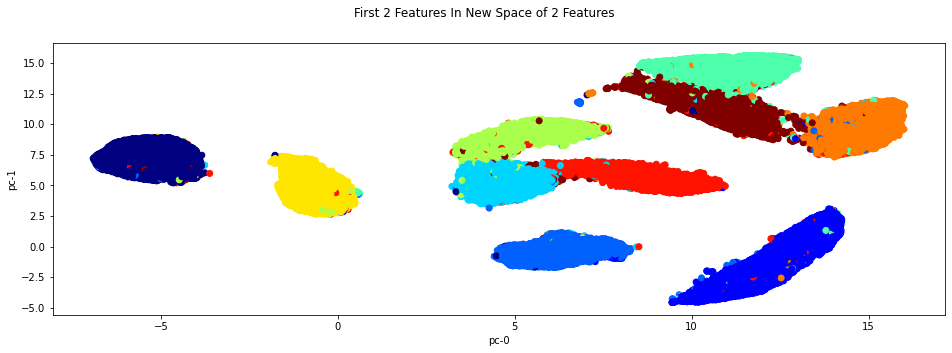

UMAP(n_neighbors=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}) - classifier of type SVC() in the new space got score of: 0.9475
visualizing features of UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


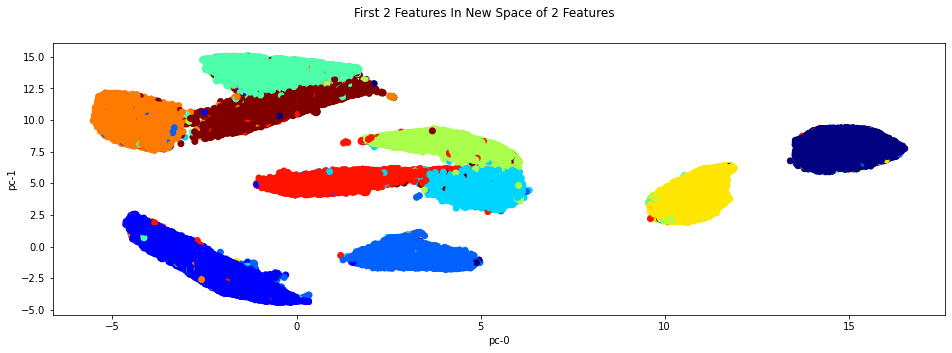

UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}) - classifier of type SVC() in the new space got score of: 0.955


In [30]:
n_neighbors_to_run = [2, 5, 10, 15] if IS_EXPERIMENT_RUN else [15] # todo

for clf_type in CLF_TO_TEST:
    for n_neighbors in n_neighbors_to_run:
        start_time = datetime.utcnow()
        umap_transformer = umap.UMAP(n_neighbors=n_neighbors, random_state=42)
        X_train_new_space, X_test_new_space = _reduce_dim(umap_transformer, X_train, X_test)
        
        print(f'visualizing features of {str(umap_transformer)}')
        _visualize_features(X_train_new_space, y_train)
        
        score = _train_and_evaluate_results(umap_transformer, X_train_new_space, 
                                            X_test_new_space, y_train, y_test, clf_type=clf_type)
        
        duration = (datetime.utcnow() - start_time).total_seconds()
    
        df = df.append([{'alg': str(umap_transformer), 'test_score': score,
                               'duration': duration, 'clf_type': clf_type, 'n_neighbors': n_neighbors}])
    
#         df.to_csv('all_results.csv')

### Preparing DataFrame + analysis for Report 

In [31]:
def _get_alg(x):
    if not isinstance(x, str):
        return ''
    
    if 'TSNE' in x:
        return 'TSNE'
    if 'UMAP' in x:
        return 'UMAP'
    if 'PCA' in x:
        return 'PCA'
    assert False

df.rename(columns={'alg': 'algorithm_obj'}, inplace=True)
df['algorithm'] = df.algorithm_obj.apply(_get_alg)

In [32]:
df[(df['clf_type'] == 'svm')].groupby(['algorithm'], dropna=False).test_score.describe()

count      mean       std     min       25%      50%       75%  \
algorithm                                                                   
             1.0  0.979200       NaN  0.9792  0.979200  0.97920  0.979200   
PCA         12.0  0.899425  0.163016  0.4779  0.928550  0.97940  0.983000   
TSNE        10.0  0.979200  0.000000  0.9792  0.979200  0.97920  0.979200   
UMAP         4.0  0.730950  0.406525  0.1223  0.704825  0.92325  0.949375   

              max  
algorithm          
           0.9792  
PCA        0.9840  
TSNE       0.9792  
UMAP       0.9550

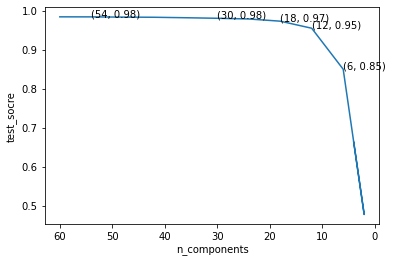

In [33]:
# PCA n_components vs. score
fig, ax = plt.subplots(1)

df[(df['algorithm']=='PCA') &
    (df['clf_type'] == 'svm')].plot(x='n_components', y='test_score', ax=ax)

ax.invert_xaxis()

for i, row in df[(df['algorithm']=='PCA') & (df['clf_type'] == 'svm')].iterrows():
    if row['n_components'] not in (54,30, 18, 12, 6):
        continue
    x = row['n_components']
    y = row['test_score']
    ax.annotate(f'({x}, {y:.2f})', xy=(x,y), textcoords='data')

ax.set_ylabel('test_socre')
ax.get_legend().remove()
plt.show()

In [34]:
df[(df['algorithm']=='TSNE') &
    (df['clf_type'] == 'mlp') 
  ].sort_values(['test_score'], ascending=False)[
    ['algorithm', 'n_components', 'test_score', 'params', 'n_neighbors']]

algorithm n_components  test_score  \
0      TSNE            2      0.9478   
0      TSNE            2      0.9466   
0      TSNE            2      0.9460   
0      TSNE            2      0.9448   
0      TSNE            2      0.9444   
0      TSNE            2      0.9436   
0      TSNE            2      0.9430   
0      TSNE            2      0.9409   
0      TSNE            2      0.9401   
0      TSNE            2      0.9303   

                                                           params  n_neighbors  
0  {'n_components': 2, 'perplexity': 100, 'method': 'barnes_hut'}          2.0  
0    {'n_components': 2, 'perplexity': 2, 'method': 'barnes_hut'}          2.0  
0    {'n_components': 2, 'perplexity': 2, 'method': 'barnes_hut'}          1.0  
0   {'n_components': 2, 'perplexity': 50, 'method': 'barnes_hut'}          2.0  
0   {'n_components': 2, 'perplexity': 50, 'method': 'barnes_hut'}          1.0  
0    {'n_components': 2, 'perplexity': 5, 'method': 'barnes_hut'}          2.0  
0    {'n_components': 2, 'perplexity': 5, 'method': 'barnes_hut'}          1.0  
0   {'n_components': 2, 'perplexity': 30, 'method': 'barnes_hut'}          2.0  
0   {'n_components': 2, 'perplexity': 30, 'method': 'barnes_hut'}          1.0  
0  {'n_components': 2, 'perplexity': 100, 'method': 'barnes_hut'}          1.0

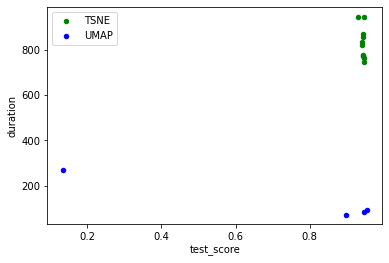

duration                                     test_score          \
                 mean      median         max         min       mean  median   
algorithm                                                                      
TSNE       832.074581  826.221647  944.281874  747.027903   0.942750  0.9440   
UMAP       129.781535   88.683560  268.379134   73.379888   0.733025  0.9222   

                           
              max     min  
algorithm                  
TSNE       0.9478  0.9303  
UMAP       0.9543  0.1334

In [37]:
df_tsne_vs_umap = df[
     (
         (
        (df['algorithm']=='TSNE') &
       (df['params'].str.contains('barnes_hut')) 
    ) | (df['algorithm']=='UMAP')
     )
    &
    (df['clf_type'] == 'mlp') ]

_, ax = plt.subplots(1)

df_tsne_vs_umap[df_tsne_vs_umap['algorithm']=='TSNE'].plot.scatter(
    x='test_score', y='duration', ax=ax, color='g', label='TSNE')
df_tsne_vs_umap[df_tsne_vs_umap['algorithm']=='UMAP'].plot.scatter(
    x='test_score', y='duration',  ax=ax, color='b', label='UMAP')

plt.show()

display(
    df_tsne_vs_umap.groupby(['algorithm']).agg({'duration': ['mean', 'median', 'max', 'min'],
                                               'test_score': ['mean', 'median', 'max', 'min']}))

# Part 3: Classification of the raw data

In [38]:
###############################################################
########## Part 4: Classification of the raw data #############
###############################################################

knn = KNeighborsClassifier(n_neighbors = 3)  
knn.fit(X_train, y_train)
predicted = knn.predict(X_test)
print(f"KNN testset accuracy: {calc_accuracy(predicted, y_test):.4f}")

KNN testset accuracy: 0.9705


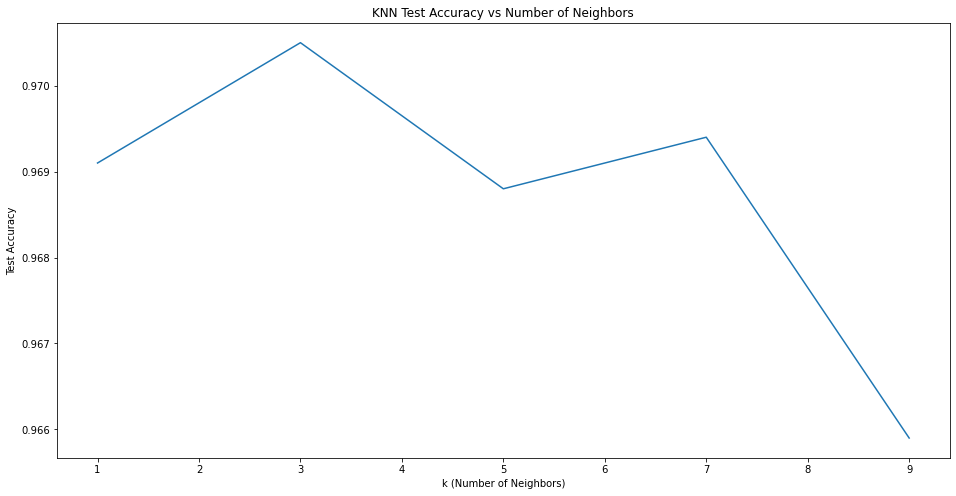

In this part we chose to explore the parameter of number of nearest neighbours.
Although minimal in accuracy difference, k=3 seems to yield the best results.
k=3 accuracy: 0.9705
This could be explained by:
 1. Overlapping of classes, they are not sparsely separated
 2. High number of samples, looking at smaller subsets will most likely find a very similar sample.


In [39]:
# In this part we chose to explore the parameter of number of nearest neihbours

k_values = [1, 3, 5, 7, 9]
k_accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    predicted = knn.predict(X_test)
    accuracy = calc_accuracy(predicted, y_test)
    k_accuracies.append(accuracy)
    
best_acc = np.max(k_accuracies)

plt.figure(figsize=(16,8))
plt.plot(k_values, np.array(k_accuracies))
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Test Accuracy')
plt.title('KNN Test Accuracy vs Number of Neighbors')
plt.show()

print("In this part we chose to explore the parameter of number of nearest neighbours.")
print("Although minimal in accuracy difference, k=3 seems to yield the best results.")
print(f"k=3 accuracy: {best_acc:.4f}")
print("This could be explained by:")
print(" 1. Overlapping of classes, they are not sparsely separated")
print(" 2. High number of samples, looking at smaller subsets will most likely find a very similar sample.")

# Part 4: Summary

In [40]:
print("*** Short summary of parts 1-3 ***")
print(f"K-means++ Testset accuracy: {calc_accuracy(kmeans_pp_test_pred, y_test):.4f}")
print(f"MLP over data using PCA with 18 components : {0.98}")
print(f"KNN testset accuracy: {calc_accuracy(predicted, y_test):.4f}")

*** Short summary of parts 1-3 ***
K-means++ Testset accuracy: 0.8548
MLP over data using PCA with 18 components : 0.98
KNN testset accuracy: 0.9659


Our findings demonstrate that a straightforward classification approach can effectively surpass unsupervised methods in a supervised classification task. Moreover in part 2, we conduct comprehensive experiments on various hyperparameters to carefully analyze three distinct dimensionality reduction algorithms. Our results reveal that we can successfully reduce the dimensionality of the data while preserving essential characteristics and information from the original space by selecting a specific set of hyperparameters for each algorithm.

Please refer to our report for a more comprehensive explenation.